In [1]:
from pandas import read_hdf
from nenequitia.datasets import DataFrameDataset
from nenequitia.models import AttentionalModule, RnnModule

model = RnnModule.load_from_checkpoint("explogs/RnnModule/3/checkpoints/sample-epoch=12.ckpt")
model.eval()
encoder = model.encoder
df = read_hdf("preds.hdf")
df["transcription"] = df.text
ds = DataFrameDataset(
    df,
    encoder=encoder,
    is_gt=False
)

In [7]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

t = Trainer(
    accelerator="gpu",
    devices=1,
    precision=16
)
preds = []

def collate_pred(strings):
    lengths = [string.shape[0] for string in strings]
    return (
        (
           pad_sequence(strings, batch_first=True, padding_value=model.encoder.pad),
           torch.tensor(lengths)
        )
    )
    
for batch in t.predict(
    model, 
    dataloaders=DataLoader(
        ds,
        batch_size=256,
        collate_fn=collate_pred
    )
):
    preds.extend(batch)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [8]:
df["Prediction"] = preds

In [9]:
df.to_hdf("preds-completed.hdf", key="df")

In [10]:
df.head()

,lang,century,page,manuscript,text,transcription,Prediction
0,lat,10,f14,btv1b10032123t,apparente. Iuno .i. aer splendore eꝰ. illustrat᷑.,apparente. Iuno .i. aer splendore eꝰ. illustrat᷑.,Good
1,lat,10,f14,btv1b10032123t,ẜlaciditatem quandam et serenttatẽ ab eo,ẜlaciditatem quandam et serenttatẽ ab eo,Good
2,lat,10,f14,btv1b10032123t,sus cipit. Quuntiq idem phoeb fecerat subuola,sus cipit. Quuntiq idem phoeb fecerat subuola,Good
3,lat,10,f14,btv1b10032123t,re: filias ad conspectum parentũ subuolare,re: filias ad conspectum parentũ subuolare,Good
4,lat,10,f14,btv1b10032123t,.. conscendere adconspectũ parentũ. iouis,.. conscendere adconspectũ parentũ. iouis,Acceptable


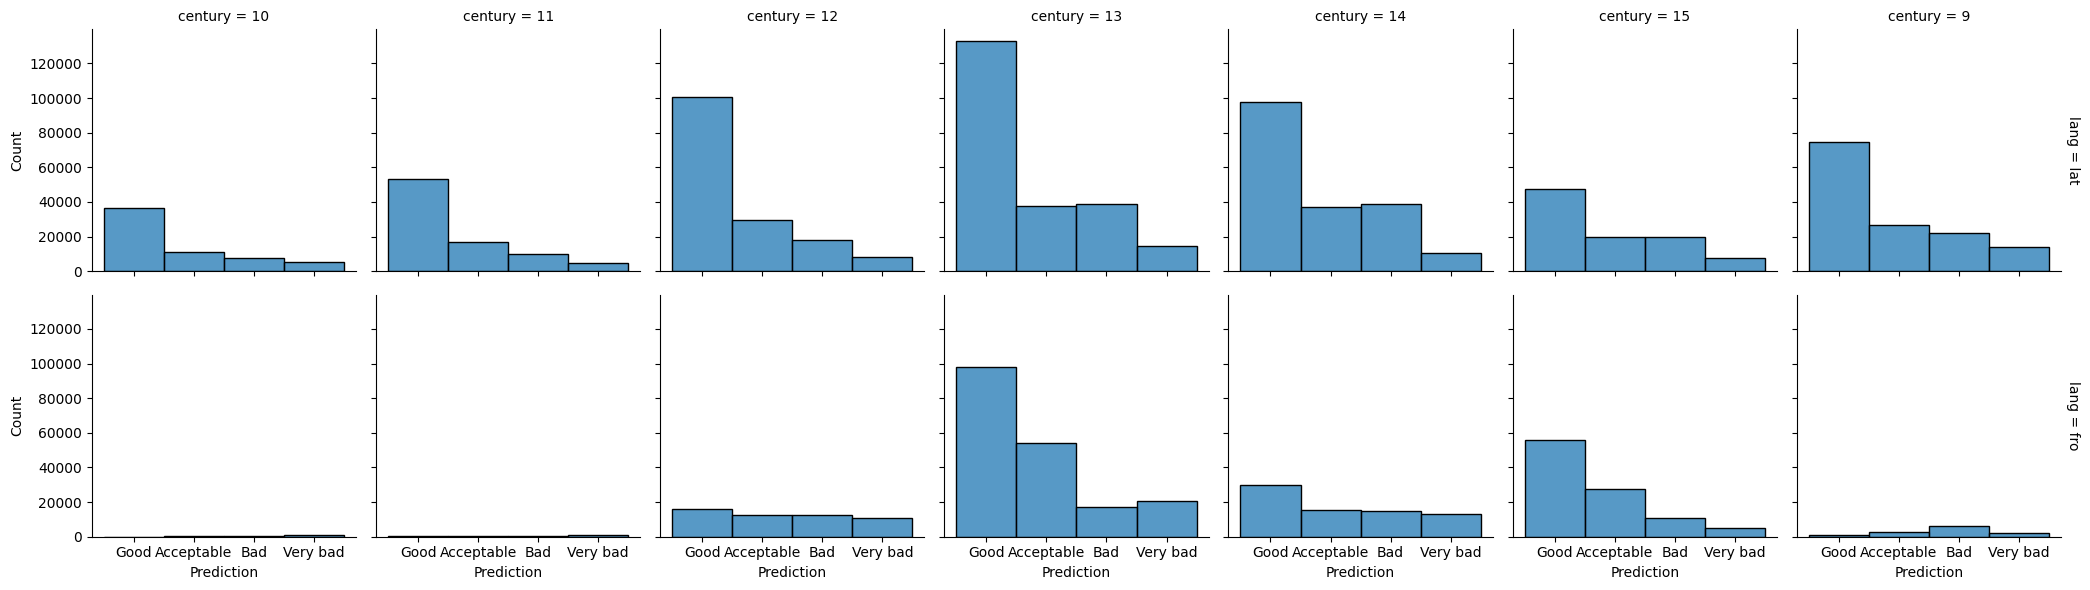

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(
    df, x="Prediction", col="century", row="lang",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)